In [1]:
# load the pre-trained tokenizer
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('panas1', max_len=512)

# load the pre-trained model
from transformers import RobertaForMaskedLM
model = RobertaForMaskedLM.from_pretrained('./panas1')

import torch
from tqdm.auto import tqdm
from pathlib import Path
paths = [str(x) for x in Path('./data/text/oscar_uk').glob('**/*.txt')]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

In [2]:
# get training data:
with open('./data/text/oscar_uk/text_5.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
# get validation data
with open('./data/text/oscar_uk/text_1556.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')

batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3

valencodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
valdataset = Dataset(valencodings)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=1, shuffle=True)

In [4]:
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [5]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

In [6]:
import numpy as np
epochs = 1
loss_hist = []
best_model = None
best_val_loss = np.Inf
val_loss_hist = []
max_cnt = 100

In [7]:
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)        
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        cnt = 0
        valloss = 0
        valloop = tqdm(valloader, leave=True)
        if cnt<max_cnt:
            with torch.no_grad():
                valbatch = next(iter(valloader))
                valinput_ids = valbatch['input_ids'].to(device)
                valattention_mask = valbatch['attention_mask'].to(device)
                vallabels = valbatch['labels'].to(device)
                valoutputs = model(valinput_ids, attention_mask=valattention_mask,
                        labels=vallabels)
                valloss += valoutputs.loss
        valloss = valloss/max_cnt
        val_loss_hist.append(valloss)
        if valloss<best_val_loss:
            best_model = model
            best_val_loss = valloss
    model = best_model

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

tensor(0.1601, device='cuda:0', grad_fn=<NllLossBackward>)


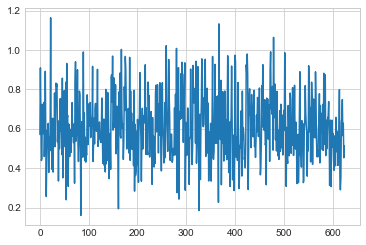

In [9]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

In [10]:
min(val_loss_hist)

tensor(0.0001, device='cuda:0')

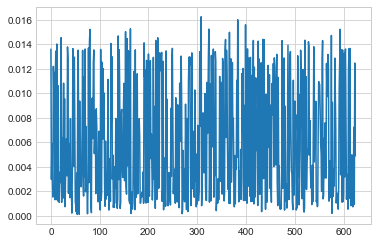

In [11]:
val_losses = [x.to('cpu').detach().numpy() for x in val_loss_hist]
plt.plot(val_losses)

In [12]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model=model.to('cpu'), tokenizer=tokenizer)

C:\Users\Asus\anaconda3\envs\torch\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [13]:
# could you plpease tell me where is...?
unmasker(f'Скажіть, будь ласка, де  {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скажіть, будь ласка, де?',
  'score': 0.4786141514778137,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скажіть, будь ласка, де запорож?',
  'score': 0.0003422977461013943,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': 'Скажіть, будь ласка, де компонент?',
  'score': 0.0002764979435596615,
  'token': 21004,
  'token_str': ' компонент'},
 {'sequence': 'Скажіть, будь ласка, де суддею?',
  'score': 0.000246429699473083,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': 'Скажіть, будь ласка, де Кодексом?',
  'score': 0.00022481042833533138,
  'token': 15877,
  'token_str': ' Кодексом'}]

In [14]:
# How old are you?
# Скільки тобі років?
unmasker(f'Скільки тобі {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скільки тобі?',
  'score': 0.47895148396492004,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки тобі оборот?',
  'score': 0.000387041422072798,
  'token': 19393,
  'token_str': ' оборот'},
 {'sequence': 'Скільки тобі Всього?',
  'score': 0.00034020590828731656,
  'token': 13600,
  'token_str': ' Всього'},
 {'sequence': 'Скільки тобі запорож?',
  'score': 0.0002707442326936871,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': 'Скільки тобі суддею?',
  'score': 0.0002643300103954971,
  'token': 25381,
  'token_str': ' суддею'}]

In [15]:
# I am thirsty
# Я хочу пити
unmasker(f'Я хочу {unmasker.tokenizer.mask_token}.')

[{'sequence': 'Я хочу.',
  'score': 0.32205432653427124,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Я хочу запорож.',
  'score': 0.0005237467121332884,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': 'Я хочу суддею.',
  'score': 0.00031103898072615266,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': 'Я хочу рости.',
  'score': 0.00029754277784377337,
  'token': 29933,
  'token_str': ' рости'},
 {'sequence': 'Я хочу Кодексом.',
  'score': 0.00026569125475361943,
  'token': 15877,
  'token_str': ' Кодексом'}]

In [16]:
unmasker(f'{unmasker.tokenizer.mask_token} хочу пити.')

[{'sequence': ' хочу пити.',
  'score': 0.2397659868001938,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': '2008 хочу пити.',
  'score': 0.0004038633778691292,
  'token': 8542,
  'token_str': '2008'},
 {'sequence': 'єктами хочу пити.',
  'score': 0.00036567336064763367,
  'token': 9303,
  'token_str': 'єктами'},
 {'sequence': 'НЕ хочу пити.',
  'score': 0.0003373397630639374,
  'token': 7048,
  'token_str': 'НЕ'},
 {'sequence': ' сільськогосподар хочу пити.',
  'score': 0.0003369803016539663,
  'token': 5322,
  'token_str': ' сільськогосподар'}]

In [17]:
# Speak slower please
# Говоріть повільніше, будь ласка
unmasker(f'{unmasker.tokenizer.mask_token} повільніше, будь ласка.')

[{'sequence': ' повільніше, будь ласка.',
  'score': 0.4662797152996063,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' запорож повільніше, будь ласка.',
  'score': 0.000510301033500582,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': ' суддею повільніше, будь ласка.',
  'score': 0.00038210468483157456,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': ' чудовим повільніше, будь ласка.',
  'score': 0.00031974550802260637,
  'token': 26567,
  'token_str': ' чудовим'},
 {'sequence': '2008 повільніше, будь ласка.',
  'score': 0.00026935417554341257,
  'token': 8542,
  'token_str': '2008'}]

In [18]:
# How much is this?
# Скільки це коштує?
unmasker(f'Скільки це {unmasker.tokenizer.mask_token} ?')

[{'sequence': 'Скільки це?',
  'score': 0.4532758295536041,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки це втім?',
  'score': 0.0003078171284869313,
  'token': 25016,
  'token_str': ' втім'},
 {'sequence': 'Скільки це орф?',
  'score': 0.0002984871680382639,
  'token': 27466,
  'token_str': ' орф'},
 {'sequence': 'Скільки це суддею?',
  'score': 0.00029070439632050693,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': 'Скільки це2008?',
  'score': 0.0002870148455258459,
  'token': 8542,
  'token_str': '2008'}]

In [19]:
# Bye!
# До побачення!
unmasker(f'{unmasker.tokenizer.mask_token} побачення!')

[{'sequence': ' побачення!',
  'score': 0.3080398142337799,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' запорож побачення!',
  'score': 0.00038993926136754453,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': ' суддею побачення!',
  'score': 0.0003207602130714804,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': ' хвили побачення!',
  'score': 0.00031457265140488744,
  'token': 8583,
  'token_str': ' хвили'},
 {'sequence': ' публічні побачення!',
  'score': 0.0003053975524380803,
  'token': 25851,
  'token_str': ' публічні'}]

In [20]:
with open('./data/text/oscar_uk/text_6.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [21]:
model.to(device)
model.train()
optim = AdamW(model.parameters(), lr=1e-4)

In [22]:
loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)        
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        cnt = 0
        valloss = 0
        valloop = tqdm(valloader, leave=True)
        if cnt<max_cnt:
            with torch.no_grad():
                valbatch = next(iter(valloader))
                valinput_ids = valbatch['input_ids'].to(device)
                valattention_mask = valbatch['attention_mask'].to(device)
                vallabels = valbatch['labels'].to(device)
                valoutputs = model(valinput_ids, attention_mask=valattention_mask,
                        labels=vallabels)
                valloss += valoutputs.loss
        valloss = valloss/max_cnt
        val_loss_hist.append(valloss)
        if valloss<best_val_loss:
            best_model = model
            best_val_loss = valloss
    model = best_model

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward>)


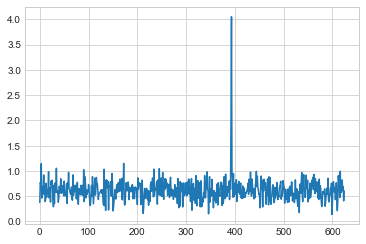

In [23]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

tensor(8.9934e-05, device='cuda:0')


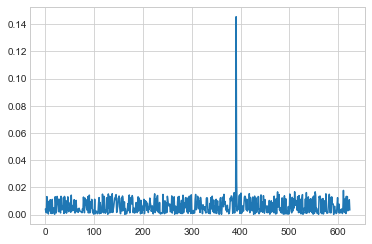

In [24]:
print(min(val_loss_hist))
val_losses = [x.to('cpu').detach().numpy() for x in val_loss_hist]
plt.plot(val_losses)

In [25]:
unmasker = pipeline("fill-mask", model=model.to('cpu'), tokenizer=tokenizer)

In [26]:
# could you plpease tell me where is...?
unmasker(f'Скажіть, будь ласка, де  {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скажіть, будь ласка, де?',
  'score': 0.25070539116859436,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скажіть, будь ласка, де визначаються?',
  'score': 0.0005581802688539028,
  'token': 12263,
  'token_str': ' визначаються'},
 {'sequence': 'Скажіть, будь ласка, десять?',
  'score': 0.0003740930405911058,
  'token': 5159,
  'token_str': 'сять'},
 {'sequence': 'Скажіть, будь ласка, де Мате?',
  'score': 0.0003292816109023988,
  'token': 22643,
  'token_str': ' Мате'},
 {'sequence': 'Скажіть, будь ласка, де доступ?',
  'score': 0.00029522666591219604,
  'token': 2068,
  'token_str': ' доступ'}]

In [27]:
# How old are you?
# Скільки тобі років?
unmasker(f'Скільки тобі {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скільки тобі?',
  'score': 0.24789085984230042,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки тобі невеликих?',
  'score': 0.0005159270367585123,
  'token': 16491,
  'token_str': ' невеликих'},
 {'sequence': 'Скільки тобіліть?',
  'score': 0.0004905581008642912,
  'token': 21586,
  'token_str': 'літь'},
 {'sequence': 'Скільки тобіces?',
  'score': 0.0004578772350214422,
  'token': 20474,
  'token_str': 'ces'},
 {'sequence': 'Скільки тобі суддею?',
  'score': 0.00044300415902398527,
  'token': 25381,
  'token_str': ' суддею'}]

In [28]:
# I am thirsty
# Я хочу пити
unmasker(f'Я хочу {unmasker.tokenizer.mask_token}.')

[{'sequence': 'Я хочу.',
  'score': 0.3305629789829254,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Я хочу отримуєте.',
  'score': 0.00039556281990371644,
  'token': 28476,
  'token_str': ' отримуєте'},
 {'sequence': 'Я хочу змогу.',
  'score': 0.0003024406614713371,
  'token': 5883,
  'token_str': ' змогу'},
 {'sequence': 'Я хочу повідомляли.',
  'score': 0.00027519671129994094,
  'token': 24757,
  'token_str': ' повідомляли'},
 {'sequence': 'Я хочусять.',
  'score': 0.0002631841925904155,
  'token': 5159,
  'token_str': 'сять'}]

In [29]:
unmasker(f'{unmasker.tokenizer.mask_token} хочу пити.')

[{'sequence': ' хочу пити.',
  'score': 0.06579091399908066,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' казки хочу пити.',
  'score': 0.0005417931824922562,
  'token': 16167,
  'token_str': ' казки'},
 {'sequence': 'ix хочу пити.',
  'score': 0.00047911194269545376,
  'token': 15299,
  'token_str': 'ix'},
 {'sequence': 'сять хочу пити.',
  'score': 0.00042675648001022637,
  'token': 5159,
  'token_str': 'сять'},
 {'sequence': 'оре хочу пити.',
  'score': 0.0004188344464637339,
  'token': 1810,
  'token_str': 'оре'}]

In [30]:
# Speak slower please
# Говоріть повільніше, будь ласка
unmasker(f'{unmasker.tokenizer.mask_token} повільніше, будь ласка.')

[{'sequence': ' повільніше, будь ласка.',
  'score': 0.13865716755390167,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'отель повільніше, будь ласка.',
  'score': 0.00042240804759785533,
  'token': 15384,
  'token_str': 'отель'},
 {'sequence': ' Миргород повільніше, будь ласка.',
  'score': 0.0004027879040222615,
  'token': 19503,
  'token_str': ' Миргород'},
 {'sequence': ' ваги повільніше, будь ласка.',
  'score': 0.00040123634971678257,
  'token': 11841,
  'token_str': ' ваги'},
 {'sequence': '\u200e повільніше, будь ласка.',
  'score': 0.0003814497613348067,
  'token': 5576,
  'token_str': '\u200e'}]

In [31]:
# How much is this?
# Скільки це коштує?
unmasker(f'Скільки це {unmasker.tokenizer.mask_token} ?')

[{'sequence': 'Скільки це?',
  'score': 0.23137111961841583,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки це розпов?',
  'score': 0.00048692108248360455,
  'token': 3498,
  'token_str': ' розпов'},
 {'sequence': 'Скільки цесять?',
  'score': 0.0004072892770636827,
  'token': 5159,
  'token_str': 'сять'},
 {'sequence': 'Скільки це суддею?',
  'score': 0.0003720525710377842,
  'token': 25381,
  'token_str': ' суддею'},
 {'sequence': 'Скільки цеure?',
  'score': 0.0003636293695308268,
  'token': 5084,
  'token_str': 'ure'}]

In [32]:
# Bye!
# До побачення!
unmasker(f'{unmasker.tokenizer.mask_token} побачення!')

[{'sequence': ' побачення!',
  'score': 0.08038903772830963,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'літь побачення!',
  'score': 0.0012392702046781778,
  'token': 21586,
  'token_str': 'літь'},
 {'sequence': ' потрібно побачення!',
  'score': 0.0004909852868877351,
  'token': 1561,
  'token_str': ' потрібно'},
 {'sequence': ' втім побачення!',
  'score': 0.0004485882818698883,
  'token': 25016,
  'token_str': ' втім'},
 {'sequence': 'копи побачення!',
  'score': 0.0004448616236913949,
  'token': 5635,
  'token_str': 'копи'}]